In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.4.1


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [4]:
filenames = tf.io.gfile.glob(str('C:/Users/Administrateur/OneDrive/Formation DATASCIENCE/Projet DATA SCIENCE/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str('C:/Users/Administrateur/OneDrive/Formation DATASCIENCE/Projet DATA SCIENCE/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1083
Pneumonia images count in training set: 3102


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\Administrateur\\OneDrive\\Formation DATASCIENCE\\Projet DATA SCIENCE\\chest_xray\\train\\PNEUMONIA\\person1352_bacteria_3442.jpeg'
b'C:\\Users\\Administrateur\\OneDrive\\Formation DATASCIENCE\\Projet DATA SCIENCE\\chest_xray\\train\\PNEUMONIA\\person641_bacteria_2533.jpeg'
b'C:\\Users\\Administrateur\\OneDrive\\Formation DATASCIENCE\\Projet DATA SCIENCE\\chest_xray\\train\\NORMAL\\IM-0622-0001-0001.jpeg'
b'C:\\Users\\Administrateur\\OneDrive\\Formation DATASCIENCE\\Projet DATA SCIENCE\\chest_xray\\train\\NORMAL\\NORMAL2-IM-1096-0001-0001.jpeg'
b'C:\\Users\\Administrateur\\OneDrive\\Formation DATASCIENCE\\Projet DATA SCIENCE\\chest_xray\\train\\PNEUMONIA\\person1670_bacteria_4426.jpeg'


In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str("C:/Users/Administrateur/OneDrive/Formation DATASCIENCE/Projet DATA SCIENCE/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [9]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [14]:
test_list_ds = tf.data.Dataset.list_files(str("C:/Users/Administrateur/OneDrive/Formation DATASCIENCE/Projet DATA SCIENCE/chest_xray/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [15]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [16]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [17]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.0523121])

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


In [23]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)


Epoch 1/25


KeyboardInterrupt: 

In [29]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [25]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights("xray_model.h5")

In [27]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [30]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)


Epoch 1/100
261/261 [==============================] - 242s 904ms/step - loss: 0.1824 - accuracy: 0.9358 - precision: 0.9797 - recall: 0.9329 - val_loss: 5.5104 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 178s 683ms/step - loss: 0.2484 - accuracy: 0.8970 - precision: 0.9726 - recall: 0.8858 - val_loss: 0.1784 - val_accuracy: 0.9346 - val_precision: 0.9823 - val_recall: 0.9290
Epoch 3/100
261/261 [==============================] - 161s 616ms/step - loss: 0.1778 - accuracy: 0.9277 - precision: 0.9807 - recall: 0.9204 - val_loss: 0.1255 - val_accuracy: 0.9481 - val_precision: 0.9535 - val_recall: 0.9781
Epoch 4/100
261/261 [==============================] - 165s 634ms/step - loss: 0.1818 - accuracy: 0.9306 - precision: 0.9825 - recall: 0.9228 - val_loss: 0.3745 - val_accuracy: 0.8606 - val_precision: 1.0000 - val_recall: 0.8127
Epoch 5/100
261/261 [==============================] - 158s 603ms/step - loss: 0.155

In [31]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model1.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

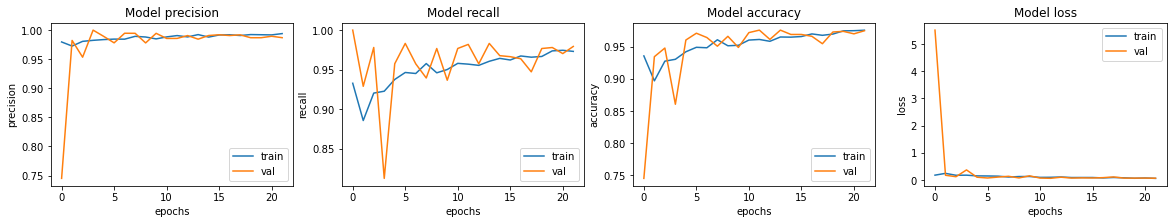

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 8s 196ms/step - loss: 0.6799 - accuracy: 0.8029 - precision: 0.7654 - recall: 0.9872


<ipython-input-37-a0442f890243>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


number of train samples across classes: 5216
number of val samples across classes: 16
number of test samples across classes: 624
number of train samples: 3662
number of val samples: 1570
Count of NORMAL images in train: 939
Count of PNEUMONIA images in train: 2723


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (None, 180, 180, 1)
